In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
%matplotlib inline
import scipy.stats as stats

ModuleNotFoundError: No module named 'pandas'

## Data Analysis

In [ ]:
## The Shape of the Data Frame 

dataFrame = pd.read_csv('Concrete_Strength.csv')            ## Load the Data
print('Data frame :', dataFrame.shape)                      ## Display the Shape
numericFeatures = list(dataFrame.columns.values)            ## Name of the features 
print('Features   : ', len(numericFeatures) - 1)            ## Print number of features
dataFrame.head()                                            ## Display the first 5 rows of the data frame

Data frame : (1030, 9)
Features   :  8


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
## Drop any duplicated rows from the data frame 

dataFrame.drop_duplicates(inplace = True)
dataFrame.reset_index(drop = True, inplace = True)

print('Data Frame shape "post duplicate removal" :', dataFrame.shape)

Data Frame shape "post duplicate removal" : (1005, 9)


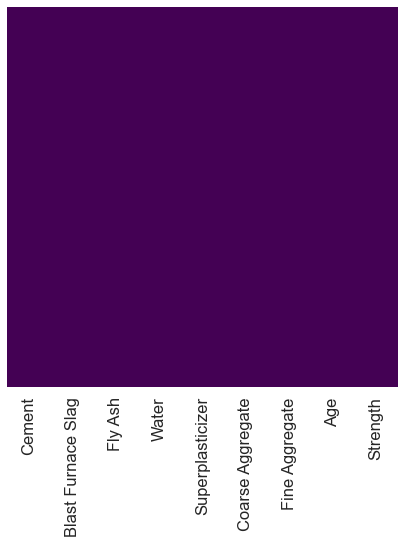

In [ ]:
## Search for any missing data for the features
plt.figure(figsize = (7, 7))
sns.heatmap(dataFrame.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

array([[<AxesSubplot:title={'center':'Cement'}>,
        <AxesSubplot:title={'center':'Blast Furnace Slag'}>,
        <AxesSubplot:title={'center':'Fly Ash'}>],
       [<AxesSubplot:title={'center':'Water'}>,
        <AxesSubplot:title={'center':'Superplasticizer'}>,
        <AxesSubplot:title={'center':'Coarse Aggregate'}>],
       [<AxesSubplot:title={'center':'Fine Aggregate'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Strength'}>]], dtype=object)

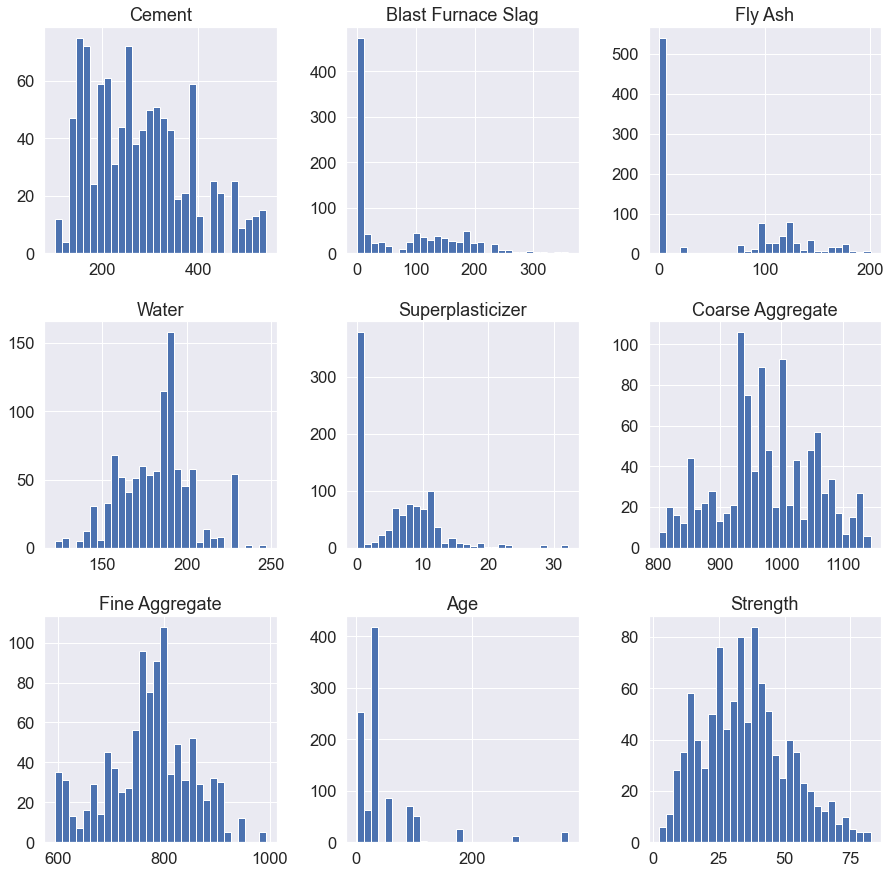

In [ ]:
dataFrame.hist(bins = 30, figsize = (15, 15))

<AxesSubplot:>

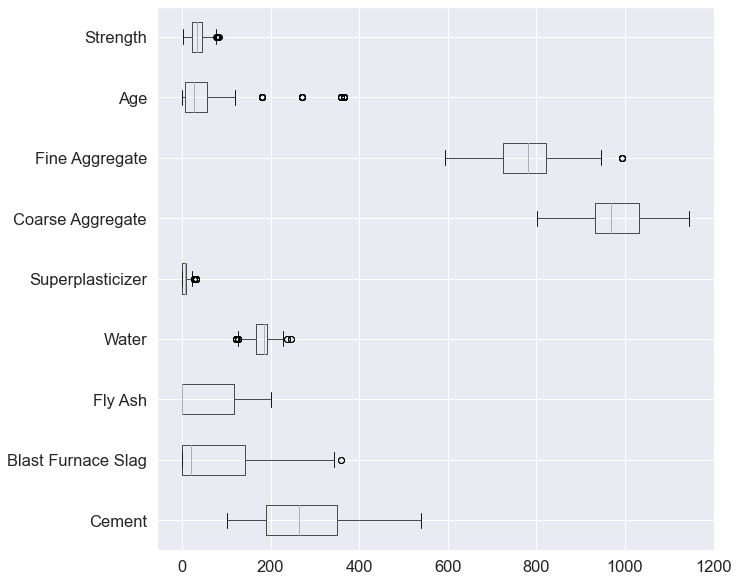

In [ ]:
dataFrame.boxplot(vert = False, grid = True, figsize = [10, 10])

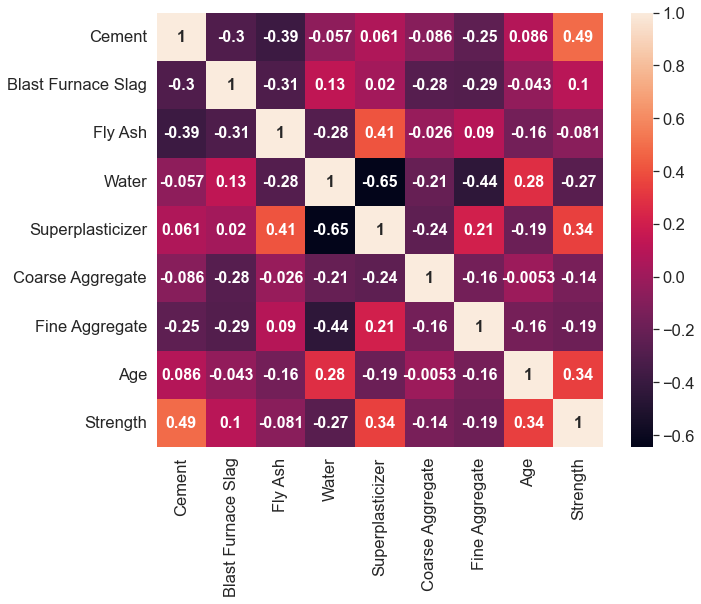

In [ ]:
## Find Correlation between features
corrMatrix = dataFrame.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corrMatrix, annot = True, annot_kws = {'fontsize':16, 'fontweight':'bold'})
sns.set(font_scale = 1.5)
plt.show()

In [ ]:
## Show the most corrlated features with the output
uLimit =  0.1   # Upper threshold
lLimit = -0.1    # Lower threshold

mostCorrFeature = corrMatrix['Strength'][(corrMatrix['Strength'] > uLimit) | (corrMatrix['Strength'] < lLimit)]  ## Find the top correlated features (negative or positive)
mostCorrFeature = mostCorrFeature[:-1]                                                                           ## Delete the last row (Strength which is self-correlated)
print(mostCorrFeature)

Cement                0.488283
Blast Furnace Slag    0.103374
Water                -0.269624
Superplasticizer      0.344209
Coarse Aggregate     -0.144717
Fine Aggregate       -0.186448
Age                   0.337367
Name: Strength, dtype: float64


In [ ]:
## Drop the least correlated features 
corrFeatures = ['Cement', 'Blast Furnace Slag', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']  
corrDataFrame = dataFrame.drop(columns = ['Fly Ash'])
print('Data Frame Size :', corrDataFrame.shape)

Data Frame Size : (1005, 8)


## Outliers 

In [ ]:
def outliers(quartile, normal, Data, FeatureName, limit):
    global inx, med, upperLimit, lowerLimit

    ## Function to define outliers in the features based on the IQR
    if quartile == 1 and normal == 0:                       
        Q1 = Data[FeatureName].quantile(0.25)               # First quantile
        Q3 = Data[FeatureName].quantile(0.75)               # Third quantile
        IQR = Q3 - Q1
        lowerLimit = 0                                      # Lower limit should be zero
        upperLimit = Q3 + limit*IQR
    
        inx = np.where((Data[FeatureName] < lowerLimit) | (Data[FeatureName] > upperLimit))[0]
        med = Data[FeatureName].median()
        mea = Data[FeatureName].mean()
        
        print("Upper limit for", FeatureName , "feature = ", upperLimit)
        print("Lower limit for", FeatureName , "feature = ", lowerLimit)
        print("The Median for", FeatureName, "=", med)
        print("The Mean for", FeatureName, "=", mea)
        print('Number of outliers based on IQR for', FeatureName, 'is', len(inx))
    
    ## Function to define outliers in the features based on the Z-score
    elif quartile == 0 and normal == 1:                     
        Z_score = stats.zscore(Data[FeatureName])    
        inx = np.where(np.abs(Z_score) > limit)[0]
        med = Data[FeatureName].median()
        mea = Data[FeatureName].mean()
        
        upperLimit = Data[FeatureName].mean() + limit*Data[FeatureName].std()
        lowerLimit = Data[FeatureName].mean() - limit*Data[FeatureName].std()
        
        print("Upper limit for", FeatureName ,"feature = ", upperLimit)
        print("Lower limit for", FeatureName ,"feature = ", lowerLimit)
        print("The Median for", FeatureName, "=", med)
        print("The Mean for", FeatureName, "=", mea)
        print('Number of outliers based on Z-score for', FeatureName, 'is', len(inx))
    elif quartile == 0 and normal == 0:
        print('--------------No Action--------------')
        print('The matrix shape is', Data.shape)
    else:
        print('Wrong')

In [ ]:
def decision(dropRow, capMedian, capMM, Data, FeatureName, inx, med, lowerLimit, upperLimit):

    if dropRow == 1 and capMedian == 0 and capMM == 0:     
    ## Dropping the outliers
        Data.drop(inx, inplace = True)
        Data.reset_index(drop = True, inplace = True)
        print('--------------The outliers will be dropped--------------')
        print('The matrix shape is', Data.shape)
    elif dropRow == 0 and capMedian == 1 and capMM == 0:
    ## Capping  the outliers with median
        Data[FeatureName] = np.where((Data[FeatureName] > upperLimit) | (Data[FeatureName] < lowerLimit), med, Data[FeatureName])
        print('--------------The outliers will be capped with mMdian--------------')
        print('The matrix shape is', Data.shape)
    elif dropRow == 0 and capMedian == 0 and capMM == 1:
        ## Capping  the outliers with max and min
        Data[FeatureName] = np.where(Data[FeatureName] > upperLimit, upperLimit, np.where(Data[FeatureName] < lowerLimit, lowerLimit, Data[FeatureName]))
        print('--------------The outliers will be capped with Min and Max--------------')
        print('The matrix shape is', Data.shape)
    elif dropRow == 0 and capMedian == 0 and capMM == 0:
        print('--------------No Action--------------')
        print('The matrix shape is', Data.shape)
    else:
        print('Wrong')
        
    return Data               ## Return the new modified matrix with no outliers

In [ ]:
outliers(1, 0, corrDataFrame, "Cement", 1.5)
cleanDataFrame = decision(0, 0, 0, corrDataFrame, "Cement", inx, med, lowerLimit, upperLimit)

Upper limit for Cement feature =  586.45
Lower limit for Cement feature =  0
The Median for Cement = 265.0
The Mean for Cement = 278.6313432835818
Number of outliers based on IQR for Cement is 0
--------------No Action--------------
The matrix shape is (1005, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Blast Furnace Slag", 1.5)
cleanDataFrame = decision(0, 0, 0, cleanDataFrame, "Blast Furnace Slag", inx, med, lowerLimit, upperLimit)

Upper limit for Blast Furnace Slag feature =  356.25
Lower limit for Blast Furnace Slag feature =  0
The Median for Blast Furnace Slag = 20.0
The Mean for Blast Furnace Slag = 72.04348258706467
Number of outliers based on IQR for Blast Furnace Slag is 2
--------------No Action--------------
The matrix shape is (1005, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Water", 1.5)
cleanDataFrame = decision(0, 0, 0, cleanDataFrame, "Water", inx, med, lowerLimit, upperLimit)

Upper limit for Water feature =  232.35000000000002
Lower limit for Water feature =  0
The Median for Water = 185.7
The Mean for Water = 182.07532338308448
Number of outliers based on IQR for Water is 4
--------------No Action--------------
The matrix shape is (1005, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Superplasticizer", 1.5)
cleanDataFrame = decision(1, 0, 0, cleanDataFrame, "Superplasticizer", inx, med, lowerLimit, upperLimit)

Upper limit for Superplasticizer feature =  25.0
Lower limit for Superplasticizer feature =  0
The Median for Superplasticizer = 6.1
The Mean for Superplasticizer = 6.033233830845774
Number of outliers based on IQR for Superplasticizer is 10
--------------The outliers will be dropped--------------
The matrix shape is (995, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Coarse Aggregate", 1.5)
cleanDataFrame = decision(0, 0, 0, cleanDataFrame, "Coarse Aggregate", inx, med, lowerLimit, upperLimit)

Upper limit for Coarse Aggregate feature =  1197.0
Lower limit for Coarse Aggregate feature =  0
The Median for Coarse Aggregate = 968.0
The Mean for Coarse Aggregate = 975.6057286432153
Number of outliers based on IQR for Coarse Aggregate is 0
--------------No Action--------------
The matrix shape is (995, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Fine Aggregate", 1.5)
cleanDataFrame = decision(1, 0, 0, cleanDataFrame, "Fine Aggregate", inx, med, lowerLimit, upperLimit)

Upper limit for Fine Aggregate feature =  966.0500000000001
Lower limit for Fine Aggregate feature =  0
The Median for Fine Aggregate = 779.3
The Mean for Fine Aggregate = 771.7393969849236
Number of outliers based on IQR for Fine Aggregate is 5
--------------The outliers will be dropped--------------
The matrix shape is (990, 8)


In [ ]:
outliers(1, 0, cleanDataFrame, "Age", 1.5)
cleanDataFrame = decision(1, 0, 0, cleanDataFrame, "Age", inx, med, lowerLimit, upperLimit)

Upper limit for Age feature =  119.0
Lower limit for Age feature =  0
The Median for Age = 28.0
The Mean for Age = 45.99090909090909
Number of outliers based on IQR for Age is 62
--------------The outliers will be dropped--------------
The matrix shape is (928, 8)


## Dataframe statistics with outliers 

In [ ]:
dataFrame.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716,35.250378
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692,16.284815
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000,23.520000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.800000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000,44.870000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## Dataframe statistics without outliers (Cleaned)

In [ ]:
cleanDataFrame.describe()

,Cement,Blast Furnace Slag,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,272.163901,73.107328,180.971659,6.082328,976.316164,774.576401,32.016164,34.357187
std,101.738846,87.165004,19.552706,5.248805,77.672976,75.277924,28.017038,16.313298
min,102.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,189.050000,0.000000,165.600000,0.000000,932.000000,734.300000,7.000000,22.440000
50%,252.200000,20.000000,184.700000,6.700000,971.800000,779.500000,28.000000,33.085000
75%,336.125000,144.325000,192.000000,10.000000,1040.600000,821.000000,28.000000,44.280000
max,540.000000,359.400000,247.000000,22.100000,1145.000000,945.000000,100.000000,82.600000


In [ ]:
## Data Standardization
features_wTarget = np.append(corrFeatures, 'Strength')          ## Add the target "Strength"

standardDataFrame = cleanDataFrame.copy()                       ## clean data frame includes data after outliers removal including the target.
standardDataFrame[features_wTarget] = StandardScaler().fit_transform(standardDataFrame[features_wTarget])

## Data Normalization
normalizeDataFrame = cleanDataFrame.copy()
normalizeDataFrame[features_wTarget] = MinMaxScaler().fit_transform(normalizeDataFrame[features_wTarget])

## Standardized Data 

In [ ]:
standardDataFrame.describe()

,Cement,Blast Furnace Slag,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,9.280000e+02,9.280000e+02,9.280000e+02,9.280000e+02,9.280000e+02,9.280000e+02,9.280000e+02,9.280000e+02
mean,-4.322004e-16,6.359257e-16,-1.001833e-15,5.535562e-16,-1.198754e-16,-6.713679e-16,7.515540e-16,-1.074631e-16
std,1.000539e+00,1.000539e+00,1.000539e+00,1.000539e+00,1.000539e+00,1.000539e+00,1.000539e+00,1.000539e+00
min,-1.673458e+00,-8.391756e-01,-3.027896e+00,-1.159427e+00,-2.258323e+00,-2.400090e+00,-1.107643e+00,-1.964315e+00
25%,-8.173743e-01,-8.391756e-01,-7.865892e-01,-1.159427e+00,-5.708557e-01,-5.353245e-01,-8.933726e-01,-7.309137e-01
50%,-1.963327e-01,-6.096020e-01,1.907844e-01,1.177421e-01,-5.817466e-02,6.544089e-02,-1.434245e-01,-7.802674e-02
75%,6.290182e-01,8.174849e-01,5.643356e-01,7.467956e-01,8.280679e-01,6.170286e-01,-1.434245e-01,6.085932e-01
max,2.634004e+00,3.286262e+00,3.378762e+00,3.053325e+00,2.172890e+00,2.265146e+00,2.427826e+00,2.958864e+00


## Normalized Data 

In [ ]:
normalizeDataFrame.describe()

,Cement,Blast Furnace Slag,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,0.388502,0.203415,0.472617,0.275218,0.509640,0.514463,0.313295,0.398993
std,0.232280,0.242529,0.156172,0.237503,0.225794,0.214467,0.283000,0.203230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.198744,0.000000,0.349840,0.000000,0.380814,0.399715,0.060606,0.250529
50%,0.342922,0.055648,0.502396,0.303167,0.496512,0.528490,0.272727,0.383144
75%,0.534532,0.401572,0.560703,0.452489,0.696512,0.646724,0.272727,0.522611
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Machine Learning Model

In [ ]:
## (Based on Standardization) Define the inputs, output, and split the data for training and testing
X = standardDataFrame.drop(columns = ['Strength'])                                                                                                # Define the input
Y = standardDataFrame.drop(columns = ['Cement', 'Blast Furnace Slag', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age','Water'])   # Define the output
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)                                                     # Split the data into test data and training data 

## Define the Linear Regression Model
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(x_test)

RMS : 0.4732205543388283
Intercept : [-0.00897684]
Accuracy : 0.801676195596182
Coefficents : [[ 0.5023283   0.24151643 -0.28174496  0.16915563 -0.11029318 -0.1331286
   0.52742568]]
--------------------


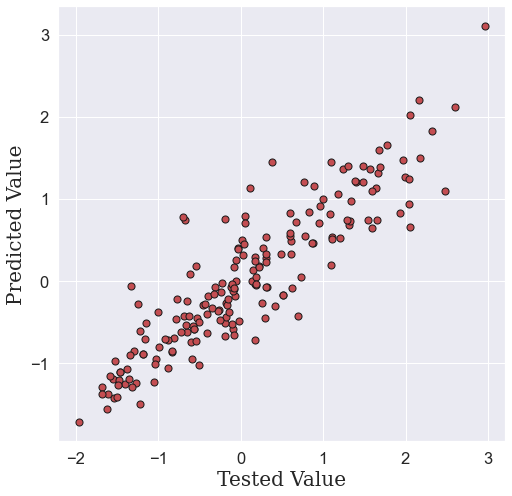

In [ ]:
## (Based on Standardization) Calculating the RMS Error, Model Coefficient, and Interception
print('RMS :', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Intercept :', model.intercept_)
print('Accuracy :', r2_score(y_test, y_pred))
print('Coefficents :', model.coef_)
print('--------------------')

## Plot the predicted results vs. testing result
plt.figure(figsize = (8, 8))
plt.scatter(y_test, y_pred, s = 50, c = 'r', edgecolors = 'k')
plt.xlabel("Tested Value", fontsize = 20, family = 'serif')
plt.ylabel("Predicted Value", fontsize = 20, family = 'serif')
plt.show()

In [ ]:
## Return the de-Standardization predictions

y_test_df = pd.DataFrame(y_test)
Y_train_df = pd.DataFrame(Y_train)
y_pred_df=pd.DataFrame(y_pred)
Y = cleanDataFrame.copy()                                   ## raw data after cleaning outliers and Nan if any 
Y = Y.drop(columns = ['Cement', 'Blast Furnace Slag', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Water'])
y_test_df_actual = y_test_df * (Y.std()) + Y.mean() ## Test Data without standardization 

y_std  = Y.std()
y_mean = Y.mean()
y_pred_df_actual= y_pred_df*(y_std[0]) +y_mean[0]   ## predicted value revert to without standardization

In [ ]:
## (Based on Normalization) Define the inputs, output, and split the data for training and testing
XN = normalizeDataFrame.drop(columns = ['Strength'])                                                                                                 # Define the input
YN = normalizeDataFrame.drop(columns = ['Cement', 'Blast Furnace Slag', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Water'])   # Define the output

X_trainN, x_testN, Y_trainN, y_testN = train_test_split(XN, YN, test_size = 0.2, random_state = 42)                   # Split the data into test data and training data 

## Define the Linear Regression Model
modelN = linear_model.LinearRegression()          
modelN.fit(X_trainN, Y_trainN)
y_predN = modelN.predict(x_testN)

RMS : 0.09612093639697032
Interception : [0.31552945]
Accuracy : 0.8016761955961819
Coefficients : [[ 0.43950464  0.20238164 -0.36664192  0.14474607 -0.09927175 -0.12615351
   0.37875882]]
--------------------


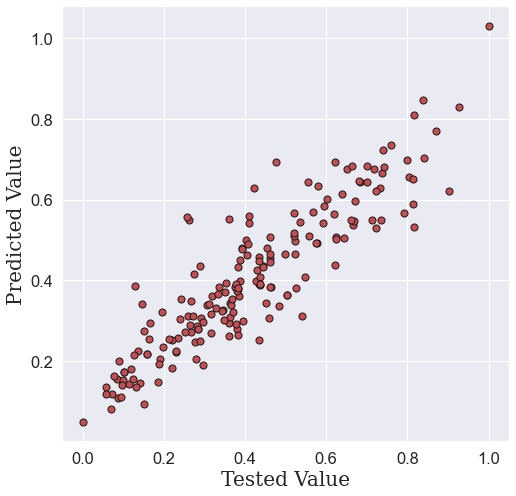

In [ ]:
## (Based on Normalization) Calculating the RMS Error, Model Coefficient, and Interception 
print('RMS :', np.sqrt(mean_squared_error(y_testN, y_predN)))
print('Interception :', modelN.intercept_)
print('Accuracy :', r2_score(y_testN, y_predN))
print('Coefficients :', modelN.coef_)
print('--------------------')

## Plot the predicted results vs. testing result
plt.figure(figsize = (8, 8))
plt.scatter(y_testN, y_predN, s = 50, c = 'r', edgecolors = 'k')
plt.xlabel("Tested Value", fontsize = 20, family = 'serif')
plt.ylabel("Predicted Value", fontsize = 20, family = 'serif')
plt.show()

# PCA

### Dimension Analysis

In [ ]:
## Drop the output and standardize the complete feature dataframe 
PCADataFrame = dataFrame.copy()                 
featuresDataFrame = PCADataFrame.drop(columns = ['Strength'])
target = PCADataFrame.drop(columns = ['Cement', 'Blast Furnace Slag' , 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Water', 'Fly Ash'])

standardDataFramePCA_features = StandardScaler().fit_transform(featuresDataFrame)       ## Standardization
z = standardDataFramePCA_features.T
covMatrix = np.cov(z)                               ## Calulate the covariance matrix

print('The size of covariance matrix is :', covMatrix.shape)

## Feature analysis for PCA  
eigValue, eigVector = np.linalg.eig(covMatrix)      ## Calculate the eigenvalue and eigenvector for the covariance matrix
inx = np.argsort(eigValue)[::-1]                    ## The index of eigenvalues components in decending order
ordEigValues = eigValue[inx]                        ## Re-arrange eigenvalues
ordEigVector = eigVector[:,inx]                     ## Re-arrange eigenvector
featureWeight = ordEigValues/ordEigValues.sum()     ## Weight for each feature (variance ratio)
featureWeight

The size of covariance matrix is : (8, 8)


array([0.28903703, 0.17858561, 0.15904341, 0.12725533, 0.12050986,
       0.09884266, 0.0229263 , 0.0037998 ])

In [ ]:
## Display the input dataframe for PCA
featuresDataFrame.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000


In [ ]:
print('The index order for eigenvalues is :', inx)  

The index order for eigenvalues is : [0 3 4 7 6 5 2 1]


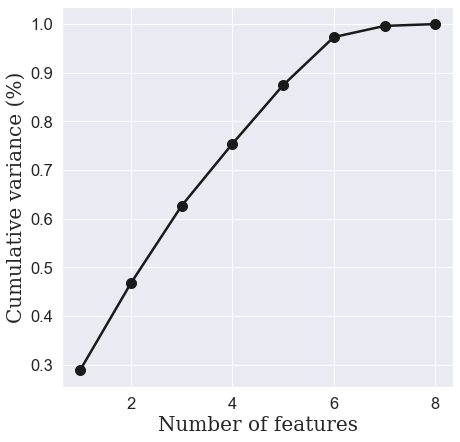

In [ ]:
## Plot the PCA dimension analysis

csum = np.cumsum(featureWeight)
xint = range(1, len(csum) + 1)
plt.figure(figsize = (7, 7))
plt.plot(xint,csum, marker = 'o', markersize = 10, linestyle = '-', color = 'k', linewidth = '2.5')

plt.xlabel("Number of features", fontsize = 20, family = 'serif')
plt.ylabel('Cumulative variance (%)', fontsize = 20, family = 'serif')
plt.show()

In [ ]:
## Apply the Principal Component Analysis (PCA) (Dimension = 2)

pcaModel = PCA(n_components = 2)                                      # Define the PCA model 
pcaModelFitTransform = pcaModel.fit_transform(featuresDataFrame)       
print(pcaModel.explained_variance_ratio_)

[0.32946286 0.24901506]


In [ ]:
print ('The PCA model dimension for inputs is :', pcaModelFitTransform.shape)
print ('The PCA model dimension for outputs is :', target.shape)

The PCA model dimension for inputs is : (1005, 2)
The PCA model dimension for outputs is : (1005, 1)


In [ ]:
X_trainPCA, x_testPCA, Y_trainPCA, y_testPCA = train_test_split(pcaModelFitTransform, target, test_size = 0.2, random_state = 42)      # Split the data into test data and training data 

## Define the Linear Regression Model
modelPCA = linear_model.LinearRegression()          
modelPCA.fit(X_trainPCA, Y_trainPCA)
y_predPCA = modelPCA.predict(x_testPCA)

In [ ]:
## (Based on Normalization) Calculating the RMS Error, Model Coefficient, and Interception 

print('RMS :', np.sqrt(mean_squared_error(y_testPCA, y_predPCA)))
print('Interception :', modelPCA.intercept_)
print('Accuracy :', r2_score(y_testPCA, y_predPCA))
print('Coefficients :', modelPCA.coef_)
print('--------------------')

RMS : 15.247915693175726
Interception : [35.12643067]
Accuracy : 0.22065190982412708
Coefficients : [[0.06096634 0.03695917]]
--------------------


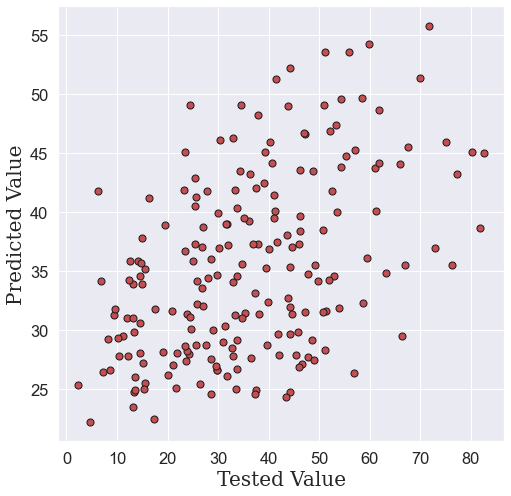

In [ ]:
## Plot the predicted results vs. testing result

plt.figure(figsize = (8, 8))
plt.scatter(y_testPCA, y_predPCA, s = 50, c = 'r', edgecolors = 'k')
plt.xlabel("Tested Value", fontsize = 20, family = 'serif')
plt.ylabel("Predicted Value", fontsize = 20, family = 'serif')
plt.show()

Reverse data from standardized to actual valeus of strength

In [ ]:
## Return the de-standardization predictions

Y_train_df = pd.DataFrame(Y_train)                          ## Converting numpay into dataframe 
y_test_df = pd.DataFrame(y_test)                            ## Converting numpay into dataframe
y_pred_df = pd.DataFrame(y_pred)                            ## Converting numpay into dataframe
                       

Y = cleanDataFrame.copy()                                   ## Make a copy of the clean dataframe 
Y = Y.drop(columns = ['Cement', 'Blast Furnace Slag', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Water'])
y_std  = Y.std()                                            ## The standard deviation for the 'Strength' 
y_mean = Y.mean()                                           ## The mean for the 'Strength'

# Outputs -Linear Regression- 
y_test_df_actual = y_test_df * (Y.std()) + Y.mean()         ## Test data without standardization
y_pred_df_actual = y_pred_df * (y_std[0]) + y_mean[0]       ## Prediction data without standardization
y_pred_df_actual.columns =['Predicted-linear Regression']

## PCA output 
y_predPCA_df = pd.DataFrame(y_predPCA)

y_predPCA_df .columns =['Predicted-PCA']

printing predictions to CSV

In [ ]:
y_pred_df_actual.to_csv('predictions_linearRegression.csv')
y_predPCA_df .to_csv('predictions_PCA.csv')
